In [1]:
## Here kkr_imp_wc will be run from uuid: '23b13d9d-6e02-46c7-b3ac-17033b205b19'
## which is the converge kkr calculation for host Bi2Te3 TI.

In [1]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
# load classes and functions
from aiida.orm import Code, Dict, load_node, StructureData
# from aiida.orm import
from aiida_kkr.tools import kkrparams
from aiida.engine import submit
from aiida_kkr.tools import kkrparams, plot_kkr
from aiida_kkr.workflows import kkr_flex_wc, kkr_imp_dos_wc, kkr_dos_wc

from aiida.orm import load_group, WorkChainNode
import matplotlib.pyplot as plt

In [3]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups,
                      WorkChainNode)
from aiida.engine import submit
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username

In [5]:
## Set the metadata options and code
metadata_option_1 = {'max_wallclock_seconds': 36000,'resources': 
               {'tot_num_mpiprocs': 48, 'num_machines': 1},
              'custom_scheduler_commands': 
              '#SBATCH --account=jara0191\n\nulimit -s unlimited; export OMP_STACKSIZE=2g',
              'withmpi': True
                    }
voro_code = Code.get_from_string('voro@claix18_init')
kkr_code = Code.get_from_string('kkr@claix18_init')
kkrimp_code = Code.get_from_string('kkrflex@claix18_init')

In [6]:
# Loading the converged kkr host calculation and the remote foder
Bi2Te3_conv_kkr = load_node('23b13d9d-6e02-46c7-b3ac-17033b205b19')
remote_last_calc_folder = Bi2Te3_conv_kkr.outputs.remote_folder


In [10]:
# Runing the host host_gf_writeout step

# setup the builder inputs
label = 'Fe:'+'Bi2Te3'
description = ('imp:d-block, repalced_atom:Bi,'+ 
               'Struc:uuid:c1626804-5b71-450c-91c4-aa7197d85279'+
               'kkr_conv:23b13d9d-6e02-46c7-b3ac-17033b205b19')

imp_info = {'Rcut': 4.0, 'Zimp': [26.0], 'ilayer_center': 4}

options, settings_imp, settings_vorostart = kkr_imp_wc.get_wf_defaults()
settings_imp['mag_init'] = True
settings_imp['retrieve_kkrflex'] = True
# settings_imp['convergence_criterion'] = 1e-8
settings_imp['nsteps'] = 100 
settings_imp['strmix'] = 0.02
settings_imp['threshold_aggressive_mixing'] = 0.05
# settings_imp['natom_in_cls_min'] = 35

builder_kkr_imp = kkr_imp_wc.get_builder()

builder_kkr_imp.options = Dict(dict=metadata_option_1)
builder_kkr_imp.metadata.label = label
builder_kkr_imp.metadata.description = description

builder_kkr_imp.impurity_info = Dict(dict=imp_info)
builder_kkr_imp.remote_data_host = remote_last_calc_folder
builder_kkr_imp.wf_parameters = Dict(dict=settings_imp)

builder_kkr_imp.voronoi = voro_code
builder_kkr_imp.kkr = kkr_code
builder_kkr_imp.kkrimp = kkrimp_code

# First kkr_imp is started here
# kkr_imp_start = submit(builder_kkr_imp)
# ilayer-3, pk:16100 uuid: 94c02cd3-57c8-4211-92bf-1478f2b93b68
# ilayer-4, pk:16637, uiid:'b146795e-3c0d-435d-924c-60834fc855a5'


Version of workflow: 0.8.1


In [9]:
from aiida.engine import workfunction
from __future__ import print_function
from __future__ import absolute_import


In [8]:
##### This is the edited part and my be final part
## By this function a long list of the single kkr_imp_wc could be run.
## Previous successful kkr_imp_wc process

from aiida.engine import workfunction
Fe_Bi2Te3_wc = load_node(16637)
host_gf = Fe_Bi2Te3_wc.outputs.remote_data_gf
imp_info_old = Fe_Bi2Te3_wc.inputs.impurity_info.get_dict()
options = Fe_Bi2Te3_wc.inputs.options

## TODO: Try to add the group_Id to load an existing group

# 
def submition_bunch_wc(parent_wc, imp_num_each_wc=None, imp_Z_list=None,builder_options=None,
                       ilayers=[],label=None,description=None, imp_setup_dict_list=None,
                       group_label= None, group_description=None,
                       ):
    import time as t
    from aiida.common.exceptions import UniquenessError, NotExistent
    from aiida.common.constants import elements as elmt
    from aiida.orm import (CifData, Code, Dict, load_node,load_group, StructureData,
                          Group)

    """
    params:
    parent_wc : (WorkchainNode, required= True): To get the impurity_info where the host
                atom will be repalced by the desired imp atom, rurun the WC.
                To get the host_gf 
    imp_num_each_wc : (int, required= False) : It represents impurity atom number palced in 
                     impurity info dict(). Either imp_num_each_wc or imp_setup_dict_list must
                     be given.
    imp_Z_list : (list, required= Flase): It contains list of all zimp for restarting the 
                 parent_imp_wc. Either imp_setup_dict_list or imp_Z_list have to be in param.
    builder_options : (dict or Dict, required = False): To setup the cluster options.
                      If not given parent_wc.option will be utilise
    ilayers: (list, required=False): This is the list of ilayers to run over the ilayer.
    

    """
## Todo: check group node, from successfull wc node, will be automatic created or not
## Todo: If not the try to add this feature
##

# To set the builder options
    if builder_options == None:
        try:
            options = parent_wc.inputs.options
        except NotExistent:
            msg = 'Neither builder_options is given nor it is found in parent_calculation'
            return msg
    else:
        options= builder_options
        print('Option is collected from params')

    # Collect required node from parent_wc
    imp_dict = parent_wc.inputs.impurity_info.get_dict()
    host_gf = parent_wc.outputs.remote_data_gf
    is_imp_dict_available = False
    #####
    bin_success_info = {}
    all_possible_dict = {}
    all_succeful_dict = {} 
    all_imp_remaider ={}
    ### 
    
    # create group and store it
    try :
        existed_group= load_group(group_label)
        print('The given Group exists in DB.  So new successfull Nodes'
              + 'will be added with the group. Group pk {}'.format(existed_group.pk))
        created_group = existed_group
    except:
        if group_label == None:
            group_label='Restarted_wc_from_uuid_{}'.format(parent_wc.uuid)
        if group_description == None:
            group_description='The parent wc impurity info {}'.format(imp_dict)
        created_group=Group(label=group_label, description=group_description)
        created_group.store()

   
    ## To create all the possible imp_settings  
    all_possible_dict = {} ## All the posssible_dict combination
    all_succeful_dict = {} ## To collect all the successfull imp_dict
    all_imp_remaider = {} ## The leftover imp_dict without sucessfull imp_dict
    
    # Create dict of impurity_info dict either from imp_setup_dict_list 
    # or by combining imp_Z_list, ilayers 
    if imp_setup_dict_list==None:
        print("No impurity setup is provided. The impurity setup will be created as follows \n\
              Combination among all the atoms in the imp_Z_list consisting imp_num_each_wc\n\
              atom in each group. Each group will be set in the ilayers position. A \n\
              combination among the ilayers element will be consider, each group will \n\
              have the same length as numbe of atoms in each atom group" )
    
        if imp_num_each_wc == 1:
            ## order the dict
            dict_order = 0
            for Z in imp_Z_list[:] :
                    for i_layer in ilayers[:]:
                        dict_order += 1
                        imp_dict['Zimp'] = Z
#                         imp_dict['ilayer_center'] = i_layer
                        copy_imp_dict = imp_dict.copy()
                        all_possible_dict[dict_order] = copy_imp_dict

            all_imp_remaider = all_possible_dict.copy()
            is_imp_dict_available = True
            
    elif isinstance(imp_setup_dict_list, list):
        dict_order = 0
        for i in range(len(imp_setup_dict_list)):
            all_possible_dict[dict_order] = imp_setup_dict_list[i] ## All the posssible_dict combination
            dict_order += 1 
        is_imp_dict_available = True
        all_imp_remaider = all_possible_dict.copy()
    else :
        is_imp_dict_available = False
        return 'No impurity info is given by the imp_setup_dict_list nor imp_num_each_wc'
    
    ##  some pre assumed or pre known values 
    ####-------------------------
    # Change the workflow parameter here for higher
    kkr_imp_wc_dict = parent_wc.inputs.wf_parameters.get_dict()
    kkr_imp_wc_dict['nsteps'] = 300
    kkr_imp_wc_dict['convergence_criterion'] = 1e-07
    kkr_imp_wc_dict['retrieve_kkrflex'] = False
    
    ####-------------------------
    if is_imp_dict_available :
        # To submit max number of wc at one time
        max_wc_submition = 8
        stop_here = False
        bin_success_info = {}
        bin_= {}   ## Use it as submitted imp info
        ## wc counting info
        builder_iter = 0 ## for tracking the submitted wc
        finished_iter = 0 ## tracking the finished wc
        total_wc = dict_order ## Total number of wc to be submitted
        
        # 
        if max_wc_submition > total_wc:
            max_wc_submition = total_wc
        created_group_node_list = list(created_group.nodes)
        group_node_label_list = [node.label for node in created_group_node_list[:]]
        ## To run all the calcualtion according to the all_possible_dict
        for order, imp_settings in all_possible_dict.items():
            ## stop_here stop all the sumbmition function if exit_status != 0
            if stop_here==True:
                break
                print('At least work chain is finished with '+
                      'exit_code not 0, and stop here break 000')

    ####---------------------------------------------------
            zatom = imp_settings['Zimp']
            imp_symbol = elmt[zatom]['symbol']
            wc_label = imp_symbol + ':Bi2Te3'
            print(wc_label)
          
            new_imp_dict = imp_settings.copy()
            ## step for sumitting the one job
            builder = parent_wc.get_builder_restart()
            # To remove 'remote_data_host' from builder dict
            builder.pop('remote_data_host')
            builder.remote_data_gf = host_gf
            builder.wf_parameters = Dict(dict=kkr_imp_wc_dict)
            builder.impurity_info = Dict(dict=new_imp_dict)
            builder.metadata.label = str(wc_label)
            builder.options = options
            builder_iter += 1
#             submition = submit(builder)
            t.sleep(30)
            ## Here the bin ony takes upto eight elements of group
            bin_element = {'pk': submition.pk,
                                  'uuid': submition.uuid,
                                  'exit_status': None,
                                  'track_num': order, 'imp_info' :new_imp_dict}
            bin_[order] = bin_element
            ## The keep the activated wc equal or below the max_wc_submition
            ## that is the maximum work-chain to be in running 
            while ((builder_iter-finished_iter >= max_wc_submition) or (total_wc == builder_iter) or (stop_here==True) ):

                t.sleep(120)
#                 print('sleeping for 120 second starting of the while loop')
                bin_success_wc = []
                bin_failure_wc = []
    
                if (len(bin_) == 0) :
                    ## Break the while loop here
                    break
                    
                for calc_order, sub_info in bin_.items():
                    wc_pk = bin_[calc_order]['pk']
                    wc_node = load_node(wc_pk)
                    if wc_node.is_finished == True:
                        if wc_node.exit_status == 0:
                            print('one clalc is finished')
                            bin_[calc_order]['exit_status']=0

                            ## To add the dict as a successfull dict
                            copy_to_success = all_possible_dict[calc_order].copy()
                            all_succeful_dict[calc_order] = (copy_to_success)

                            ## To delete the dict from the all_imp_remainder as it is the copy of all_possible_dict
                            all_imp_remaider.pop(calc_order)

                            ## To collect the successfull calc info such as pk, uuid
                            copy_sucess_info = bin_[calc_order].copy()
                           # before storing the node check is node is available there
                            if wc_node.label in group_node_label_list[:]:
                                print('The wc_node pk : {} and label {} is already exist on the group {}'.format(wc_node.pk, wc_node.label, created_group.label))
                                created_group.add_nodes(wc_node)
                            else:
                                created_group.add_nodes(wc_node)
                                
                            bin_success_info[calc_order] = copy_sucess_info
                            ## To reduce the dict from the bin_ as it is boundary that can be submit wc at one time
                            bin_success_wc.append(calc_order)
                            finished_iter += 1
                        else :
                            bin_failure_wc.append(calc_order)
                            stop_here = True
                            print('---exit_status is not 0. So, one inconistency in wc {} is found'.format(wc_pk))

                ## To delete the element from bin_ as this wc are finished 
                ## and create the new space for others
                if (bin_success_wc != []):
                    for i in bin_success_wc[:]:
                        bin_.pop(i)
                        
                if (bin_failure_wc != []):
                    for i in bin_failure_wc[:]:
                        bin_.pop(i)
                
    return all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info


imp_num_each_wc = 1
i_layers = [3]
d_elmt_zatom = [*range(29,31, 1)] + [*range(39,49, 1)]
builder_options = Dict(dict=metadata_option_1)

group_label = '3d_4d_dopants_Bi2Te3_ilayer4'

imp_setup_dict_list = [{'Rcut': 4.0, 'Zimp': 27, 'ilayer_center': 4}]

# all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info = submition_bunch_wc(parent_wc=Fe_Bi2Te3_wc, builder_options=builder_options, 
#                                                                                               imp_setup_dict_list=imp_setup_dict_list, 
#                                                                                               group_label=group_label)

# all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info  = submition_bunch_wc(parent_wc= Fe_Bi2Te3_wc, imp_num_each_wc= 1,
#                                                                                                imp_Z_list= d_elmt_zatom,builder_options= builder_options,
#                                                                                                ilayers= i_layers, group_label=group_label)

In [206]:
all_succeful_dict

{2: {'Rcut': 4.0, 'Zimp': 30, 'ilayer_center': 3},
 3: {'Rcut': 4.0, 'Zimp': 39, 'ilayer_center': 3},
 4: {'Rcut': 4.0, 'Zimp': 40, 'ilayer_center': 3},
 6: {'Rcut': 4.0, 'Zimp': 42, 'ilayer_center': 3},
 5: {'Rcut': 4.0, 'Zimp': 41, 'ilayer_center': 3},
 1: {'Rcut': 4.0, 'Zimp': 29, 'ilayer_center': 3},
 7: {'Rcut': 4.0, 'Zimp': 43, 'ilayer_center': 3},
 8: {'Rcut': 4.0, 'Zimp': 44, 'ilayer_center': 3},
 9: {'Rcut': 4.0, 'Zimp': 45, 'ilayer_center': 3},
 11: {'Rcut': 4.0, 'Zimp': 47, 'ilayer_center': 3},
 12: {'Rcut': 4.0, 'Zimp': 48, 'ilayer_center': 3},
 10: {'Rcut': 4.0, 'Zimp': 46, 'ilayer_center': 3}}

In [21]:
## This Part is intended to run the kkr_imp_dos_wc from the previous kkr_imp_wc
# Inputs:
# Features:

# Trying to run single imp DOS calculation

parent_kkrimp = load_node(21270)

## Preparation the inputs
dos_wf_parameters = {'dos_run': True,
                     'ef_shift': 0.0,
                     'dos_params': {'emax': 1.0,
                      'emin': -1.0,
                      'kmesh': [30, 30, 30],
                      'nepts': 96,
                      'tempr': 200.0,
                      'RCLUSTZ': 6.0}}

code = Code()
kkr_code = code.get_from_string('kkr@claix18_init')
kkrimp_code = code.get_from_string('kkrflex@claix18_init')
options = metadata_option_1
imp_info = parent_kkrimp.inputs.impurity_info
kkrimp_sfd = parent_kkrimp.outputs.converged_potential

# Now to submit the kkr_dos_wc node
kkrdoswc = kkr_imp_dos_wc.get_builder()

kkrdoswc.kkr = kkr_code
kkrdoswc.kkrimp = kkrimp_code
kkrdoswc.impurity_info = imp_info
# kkrdoswc.imp_pot_sfd = kkrimp_sfd
kkrdoswc.options = Dict(dict=options)
kkrdoswc.wf_parameters = Dict(dict=dos_wf_parameters)
# kkrdoswc_activate = submit(kkrdoswc)

NotExistentAttributeError: Node<21270> does not have an output with link label 'converged_potential'

In [32]:
parent_kkrimp = load_node(21270)
dos_wf_parameters = { 'dos_params': {'emax': 1.0,
                          'emin': -1.0,
                          'nepts': 96}
                        }
def dos_bunch_from_pre_dos(pre_dos_node_list: list=None, dos_wf_parameters_dict: dict = {})
    ## To define some tracking number
    tot_dos_num = 0
    tot_run_num = 0
    tot_fin_fai_num = 0
    max_runing
    for parent_kkrimp in pre_dos_node_list[:]:
    
    dos_wf_parameters = dos_wf_parameters_dict
    dos_restart = parent_kkrimp.get_builder_restart()
    dos_restart.wf_parameters = Dict(dict=dos_wf_parameters)
    dos_restart.metadata.label = "More resulation near the Fermi_Energy_label (-1,1)"
    # submission = submit(dos_restart) # 58991
    submission.label
    # dos_restart.wf_parameters.get_dict()
    # parent_kkrimp.label

'Sc:Bi2Te3_dos_(-1,1)'

In [19]:
##  To submit the a bunch of doc wc
def dos_wc_branch(parent_kkrimp_wc_group=None, parent_kkrimp_wc_list=[]):
    from aiida.engine import submit
    import time as t
    ## Preparation the inputs
    dos_wf_parameters = { 'dos_params': {'emax': 1.0,
                      'emin': -1.0,
                      'nepts': 96}
                    }
    if parent_kkrimp_wc_list!= []:
        wc_list= parent_kkrimp_wc_list
    else:
       
        parent_kkrimp_wc_group = load_group(parent_kkrimp_wc_group)
        wc_list = list(parent_kkrimp_wc_group.nodes)

   
    for node in wc_list[1:]:
        print(node.pk)
        print(node.label)
        parent_kkrimp = load_node(node.pk)

        code = Code()
        kkr_code = code.get_from_string('kkr@claix18_init')
        kkrimp_code = code.get_from_string('kkrflex@claix18_init')
        options = metadata_option_1
        imp_info = parent_kkrimp.inputs.impurity_info
        kkrimp_sfd = parent_kkrimp.outputs.converged_potential
        label = parent_kkrimp.label + 'dos'#'aiid#'aiida_kkr.workflows.gf_writeout.kkr_flex_wc':#'aiida_kkr.workflows.gf_writeout.kkr_flex_wc':#'aiida_kkr.workflows.gf_writeout.kkr_flex_wc':a_kkr.workflows.gf_writeout.kkr_flex_wc':
        # Now to submit the kkr_dos_wc node
        kkrdoswc = kkr_imp_dos_wc.get_builder()

        kkrdoswc.kkr = kkr_code
        kkrdoswc.kkrimp = kkrimp_code
        kkrdoswc.impurity_info = imp_info
        kkrdoswc.imp_pot_sfd = kkrimp_sfd
        kkrdoswc.options = Dict(dict=options)
        kkrdoswc.wf_parameters = Dict(dict=dos_wf_parameters)
        kkrdoswc.metadata.label = label
#         out_wc = submit(kkrdoswc)
        print('dos_pk : ',out_wc.pk)
    
parent_kkrimp_wc = load_node(24165)
dos_wc_branch(parent_kkrimp_wc_list=parent_kkrimp_wc)
    

16215
Ti:Bi2Te3
dos_pk :  22907
16237
V:Bi2Te3
dos_pk :  22910
16258
Cr:Bi2Te3
dos_pk :  22913
16279
Mn:Bi2Te3
dos_pk :  22916
16300
Fe:Bi2Te3
dos_pk :  22919
16349
Co:Bi2Te3
dos_pk :  22922
16369
Ni:Bi2Te3
dos_pk :  22925
22280
Zn:Bi2Te3
dos_pk :  22928
22302
Y:Bi2Te3
dos_pk :  22933
22323
Zr:Bi2Te3
dos_pk :  22938
22365
Mo:Bi2Te3
dos_pk :  22942
22344
Nb:Bi2Te3
dos_pk :  22947
22260
Cu:Bi2Te3
dos_pk :  22953
22414
Tc:Bi2Te3
dos_pk :  22956
22434
Ru:Bi2Te3
dos_pk :  22962
22614
Rh:Bi2Te3
dos_pk :  22966
22691
Ag:Bi2Te3
dos_pk :  22971
22751
Cd:Bi2Te3
dos_pk :  22975
22645
Pd:Bi2Te3
dos_pk :  22980


In [70]:
load_n = load_node(18833)
load_n.node_type =='process.workflow.workchain.WorkChainNode.'
load_n.process_class #== 'aiida_kkr.workflows.kkr_imp.kkr_imp_dos_wc'

aiida_kkr.workflows.kkr_imp.kkr_imp_wc

In [75]:
wc_dos_list = []
loaded_group = load_group(91)
wc_list = list(loaded_group.nodes)
for node in wc_list[:]:
    loaded_node = load_node(node.pk)
    dos_wc = False
    while(not dos_wc):
        outgoing_wc = [ i.outputs.converged_potential for i in wc_list[:]]
        outgoing_wc = [ i.get_outgoing().all() for i in outgoing_wc]
        outgoing_wc = [ wc for wc in outgoing_wc[:] if wc.node.node_type=='process.workflow.workchain.WorkChainNode.']
#         outgoing_wc = [ wc for wc in outgoing_wc[:] if wc.node.process_class=='aiida_kkr.workflows.kkr_imp_dos.kkr_imp_dos_wc']
        
        print(outgoing_wc)
        dos_wc = True

AttributeError: 'list' object has no attribute 'node'

In [53]:
## Dos_plotting
plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[3:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

NameError: name 'imp_dos_group' is not defined

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.gridspec as gridspec

No handles with labels found to put in legend.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


impurity_dict {'Rcut': 4.0, 'Zimp': 21, 'ilayer_center': 3}


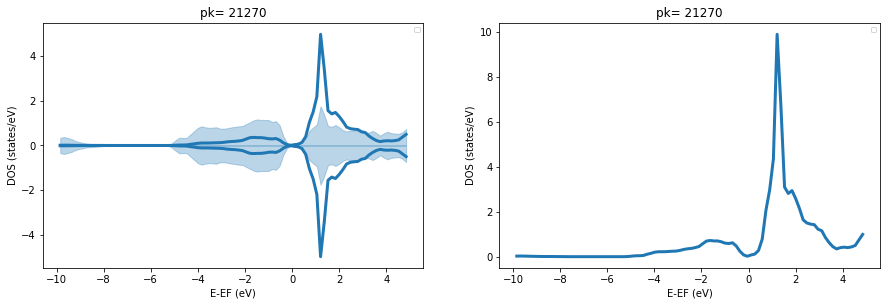

In [80]:
imp_dos = load_node(21270)
imp_info = imp_dos.label
print(imp_info)


fig2 = plt.figure(figsize=(15.0,4.5))
spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)


# Plot for host and impurity with the together 
f2_ax1 = fig2.add_subplot(spec2[0, 0])
plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True ,label= str(imp_dos.label + imp_info),
             noshow=True, nofig=True, color='C'+str(0), filled=True, alpha=0.3, yscale=0.5
        )
 # highlight the contibution of the impurity (iatom=0)
plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
         noshow=True, nofig=True, color='C'+str(0),
         lw=3, iatom=0, 
        )


f2_ax2 = fig2.add_subplot(spec2[0, 1])
plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
        noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0,all_atoms= False, sum_spins= True,)
print('impurity_dict', imp_dos.inputs.impurity_info.get_dict())

No handles with labels found to put in legend.


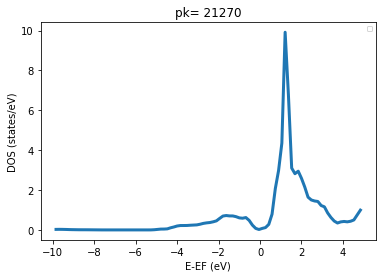

In [37]:
 plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
        noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0,all_atoms= False, sum_spins= True,)